We want to find out A of wave equation


$$\frac{1}{v^2} \frac{\delta^2 y}{\delta t^2}- \frac{\delta ^2}{\delta x^2}= 0$$

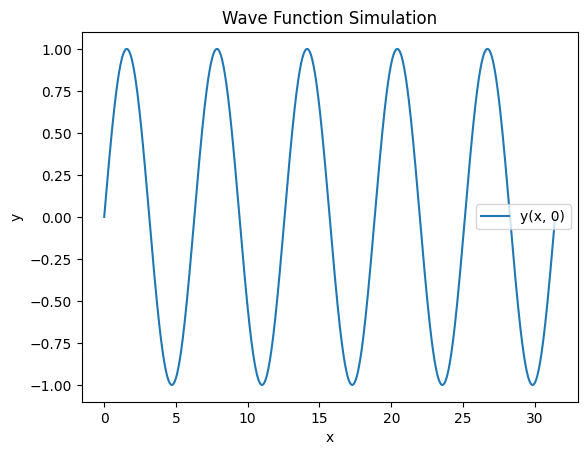

In [6]:

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from math import exp
import functools

import torch 
from torch import nn, optim
from torch.nn import functional as F

from sklearn.model_selection import train_test_split

def wave_function(x, t, A=1, v=1):
    """
    Compute the wave function y(x, t) = A * sin(x - vt).
    
    Parameters:
    - x: Array of x values.
    - t: Time parameter.
    - A: Amplitude (default is 1).
    - v: Velocity (default is 1).
    
    Returns:
    - Array of y values.
    """
    return A * np.sin(x - v * t)

# Generate x values
x_values = np.linspace(0, 10 * np.pi, 1000)

# Choose a time parameter (you can change this value)
t_parameter = 0

# Compute y values for the chosen time parameter
y_values = wave_function(x_values, t_parameter)

# Plot the wave function
plt.plot(x_values, y_values, label=f'y(x, {t_parameter})')
plt.title('Wave Function Simulation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()




In [7]:
import sys

print(sys.version)

3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


In [8]:

def u(x,t,A,v): return A*np.sin(x - v*t)

def u_diff_diff_tt(x,t,v,A): return A*(v**2)*np.sin(-x - v*t)

def u_diff_diff_xx(x,t,v,A): return A*np.sin(-x - v*t)



In [9]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, n_layers=2):
        
        super(Net, self).__init__()
        
        # model discovery parameters
        #self.A = nn.Parameter(data=torch.tensor(0.), requires_grad=True) # rate of temp change. Init=0.
        
        activation = nn.Softplus # nn.LeakyReLU, nn.Tanh, nn.ReLU, nn.ELU

        self.input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            activation()
        )
        
        self.network = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                activation()
            ) for i in range(n_layers)]
        )

        self.output = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.input(x)
        x = self.network(x)
        x = self.output(x)
        return x


In [10]:
def gradient(outputs, inputs, order=1):
    """
    Computes the partial derivative of 
    an output with respect to an input.
    Given an order, we compute the gradient multiple times.
    """
    grads = []
    for i in range(order):
        grads.append(torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0])
        outputs = grads[-1]
    
    return outputs, grads



In [11]:
A, v = 2, 4

def u(x,t): return A*np.sin(x - v*t)

def u_diff_diff_tt(x,t): return A*(v**2)*np.sin(-x - v*t)

def u_diff_diff_xx(x,t): return A*np.sin(-x - v*t)

def pde(x, t, v):
    return 1/(v**2) *u_diff_diff_tt(x,t) - u_diff_diff_xx(x,t)

def pde_loss(x, t, v, model: nn.Module):
    """
    1/v^2 * u_tt - u_xx = 0
    """

#compute the gradients
    u_tt = gradient(model(x, t), [t, t], order=2)
    u_xx = gradient(model(x, t), [x, x], order=2)

#compute the loss
    model_pde = (1/(v**2) * u_tt - u_xx)
    #true_pde = pde(x, t, v)

    loss = torch.mean((model_pde - 0)**2)

    return loss




In [ ]:
from softadapt import LossWeightedSoftAdapt

In [ ]:
# defining model
pinn = Net(input_dim=2, output_dim=1, hidden_dim=100, n_layers=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(pinn.parameters(), lr=1e-4, weight_decay=1e-5)


### training loop
epochs = 10000

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 10), nrows=5)

losses = np.zeros(epochs)
losses_data = np.zeros(epochs)
losses_physics = np.zeros(epochs)


lambda_data = np.zeros(epochs)
lambda_physics = np.zeros(epochs)


epochs_x = np.arange(epochs)

verbose = True
pinn.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    u_pred = pinn(features_) #features skal have to coloumns

    # regular data driven loss
    loss_data = criterion(u_pred, u_true)

    # ODE physics loss
    loss_physics = pde_loss(pinn, coll_points=1000)



    values_of_component_1.append(loss_data)
    values_of_component_2.append(loss_physics)
    

    
    # Change 4: Make sure `epochs_to_make_change` have passed before calling SoftAdapt.
    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(values_of_component_1), 
                                                                torch.tensor(values_of_component_2),
                                                                verbose=False,
                                                                )
                                
        # Resetting the lists to start fresh (this part is optional)
        values_of_component_1 = []
        values_of_component_2 = []
    
    # Change 5: Update the loss function with the linear combination of all components.
    loss = adapt_weights[0] * loss_data + adapt_weights[1]*loss_physics
    

    loss.backward()                 # Backward pass: Compute gradient of the loss with respect to model parameters
    optimizer.step()                # Update weights
    
    # logging
    losses_data[epoch] = loss_data.item()
    losses_physics[epoch] = loss_physics.item()
    losses[epoch] = loss.item()


    lambda_data[epoch] = adapt_weights[0].detach().numpy()
    lambda_physics[epoch] = adapt_weights[1].detach().numpy()
    
    
    if epoch % 999 == 0 and epoch != 0 and verbose:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

        # Plotting the loss
        ax[0].plot(epochs_x[:epoch], losses[:epoch], 'b')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Training Loss')
        ax[0].set_xlim(0, epochs)

        ### Plotting the function
        full_u_pred = pinn(torch.tensor(times).float().reshape(-1, 1)).detach().numpy()
        ax[1].plot(times, temps, 'black', label='Ground Truth')
        ax[1].scatter(t, T,c='blue', label='Training observations')
        ax[1].plot(times, full_u_pred, 'red', label='Prediction')
        ax[1].set_xlabel('time t')
        ax[1].set_ylabel('T(t)')
        ax[1].set_title(f'Prediction for epoch {epoch+1}/{epochs}')
        ax[1].set_ylim(0, 100)
        plt.tight_layout()

        ### Plotting the loss components
        ax[2].plot(epochs_x[:epoch], losses_data[:epoch], 'b', label='Data Loss')
        ax[2].plot(epochs_x[:epoch], losses_physics[:epoch], 'r', label='Physics Loss')
        
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('Loss')
        ax[2].set_title('Component losses')
        ax[2].set_xlim(0, epochs)
        ax[2].set_yscale("log")

        ### Plotting the weights
        ax[3].plot(epochs_x[:epoch], lambda_data[:epoch], c='b', label='Data weight')
        ax[3].plot(epochs_x[:epoch], lambda_physics[:epoch], c='r', label='Physics weight')
        ax[3].plot(epochs_x[:epoch], lambda_ic[:epoch], c='g', label='IC weight')
        ax[3].set_xlabel('Epochs')
        ax[3].set_ylabel('$\lambda$')
        ax[3].set_title('Component weights')
        ax[3].set_xlim(0, epochs)


        ax[4].plot(epochs_x[:epoch],t_diffs[:epoch], label = "The diff")
        ax[4].set_title('Mean of T_diff(t) over 1000 points')

        display.clear_output(wait=True)
        display.display(fig)
        
        # Pause a bit so that the plot updates
        plt.pause(0.1)

